In [1]:
!pip install --quiet -U langchain langchain_openai langgraph langchainhub langchain_experimental langchain_community


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [15]:
import os
import urllib

driver = '{ODBC Driver 17 for SQL Server}'
server = os.environ["SERVER"]
database = os.environ["DATABASE"]
username = os.environ["USERNAME"]
password = os.environ["PASSWORD"]

odbc_str = 'DRIVER='+driver+';SERVER='+server+';PORT=1433;UID='+username+';DATABASE='+ database + ';PWD='+ password
connect_str = 'mssql+pyodbc:///?odbc_connect=' + urllib.parse.quote_plus(odbc_str)

In [3]:
# temp_conn = 'mssql+pyodbc:///?odbc_connect=DRIVER={SQL Server};SERVER=th1.database.windows.net;DATABASE=Th-1-pgsql;Trusted_Connection=yes;'

In [16]:
print("CONN STRING")
print(connect_str)

CONN STRING
mssql+pyodbc:///?odbc_connect=DRIVER%3D%7BODBC+Driver+17+for+SQL+Server%7D%3BSERVER%3Dth1.database.windows.net%3BPORT%3D1433%3BUID%3Dth1-admin%3BDATABASE%3DTh-1-pgsql%3BPWD%3DThreSh0lD%4001


In [19]:
from langchain_community.utilities import SQLDatabase
import sqlalchemy

In [20]:
engine = sqlalchemy.create_engine(connect_str)

In [21]:
db = SQLDatabase(engine, schema="SalesLT")

In [22]:
# db = SQLDatabase.from_uri(connect_str, sc)
print(db.dialect)
print(db.get_usable_table_names())

mssql
['Address', 'Customer', 'CustomerAddress', 'Product', 'ProductCategory', 'ProductDescription', 'ProductModel', 'ProductModelProductDescription', 'SalesOrderDetail', 'SalesOrderHeader']


In [24]:
db.run("SELECT * FROM SalesLT.Address;")

'[(9, \'8713 Yosemite Ct.\', None, \'Bothell\', \'Washington\', \'United States\', \'98011\', \'268AF621-76D7-4C78-9441-144FD139821A\', datetime.datetime(2006, 7, 1, 0, 0)), (11, \'1318 Lasalle Street\', None, \'Bothell\', \'Washington\', \'United States\', \'98011\', \'981B3303-ACA2-49C7-9A96-FB670785B269\', datetime.datetime(2007, 4, 1, 0, 0)), (25, \'9178 Jumping St.\', None, \'Dallas\', \'Texas\', \'United States\', \'75201\', \'C8DF3BD9-48F0-4654-A8DD-14A67A84D3C6\', datetime.datetime(2006, 9, 1, 0, 0)), (28, \'9228 Via Del Sol\', None, \'Phoenix\', \'Arizona\', \'United States\', \'85004\', \'12AE5EE1-FC3E-468B-9B92-3B970B169774\', datetime.datetime(2005, 9, 1, 0, 0)), (32, \'26910 Indela Road\', None, \'Montreal\', \'Quebec\', \'Canada\', \'H1Y 2H5\', \'84A95F62-3AE8-4E7E-BBD5-5A6F00CD982D\', datetime.datetime(2006, 8, 1, 0, 0)), (185, \'2681 Eagle Peak\', None, \'Bellevue\', \'Washington\', \'United States\', \'98004\', \'7BCCF442-2268-46CC-8472-14C44C14E98C\', datetime.datetim

### Creating Utility Functions
*To handle errors gracefully and provide feedback to the agent, we’ll define some utility functions:*

In [25]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

### Tools for the Agent

In [26]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

In [27]:
toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4"))
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

@tool
def db_query_tool(query: str) -> str:
  """Executes query on db.

    Args:
        query: sql query being executed
    Returns:
        result: result of the query execution or error message
    """
  result = db.run_no_throw(query)
  if not result:
      return "Error: Query failed. Please rewrite your query and try again."
  return result

#### **Query Checking**

In [28]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
  [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | ChatOpenAI(model="gpt-4", temperature=0).bind_tools(
  [db_query_tool], tool_choice="required"
)

### LangGraph Workflow

In [29]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages

# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

/Users/mehulmathur/UIC/Adv_NLP/Project_Stuff/sql_agent/sql_agent/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3549: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
# Define a new graph
workflow = StateGraph(State)

In [31]:
# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [SubmitFinalAnswer]
)


def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

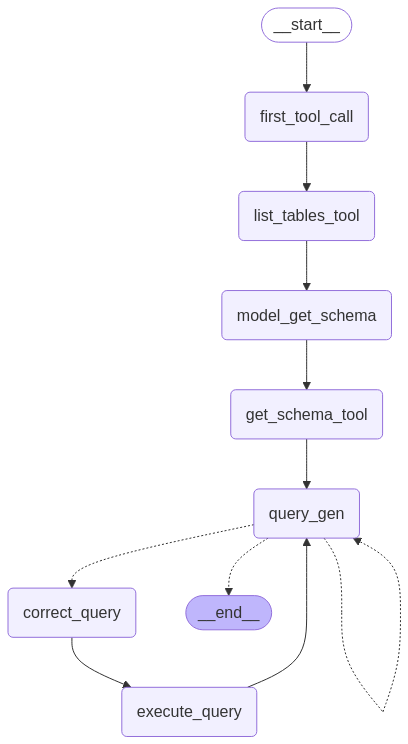

In [32]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [35]:
messages = app.invoke(
    {"messages": [("user", "List top 5 products with their names")]}
)
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]


for event in app.stream(
    {"messages": [("user", "List top 5 products with their names")]}
):
    print(event)

{'first_tool_call': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='1e02eb30-23bd-43a4-80ca-048aaff82fc9', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}])]}}
{'list_tables_tool': {'messages': [ToolMessage(content='Address, Customer, CustomerAddress, Product, ProductCategory, ProductDescription, ProductModel, ProductModelProductDescription, SalesOrderDetail, SalesOrderHeader', name='sql_db_list_tables', id='d8d045e4-4685-456d-9620-92d54dcf8c04', tool_call_id='tool_abcd123')]}}
{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_L5j1Vj58qN6XtX66C22NjZDm', 'function': {'arguments': '{"table_names":"Product"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 178, 'total_tokens': 195, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens

In [34]:
json_str

"To find the total number of customers in the database, we can count the number of entries in the Customer table. Here's the query to do that:\n\n```sql\nSELECT COUNT(*) AS TotalCustomers FROM SalesLT.Customer;\n```\n\nThis query will return the total number of customers in the database."